In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Preliminary Data Cleaning

In [8]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
# Set seeds for reproducibility for whole kernel
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

df = pd.read_csv('lung cancer survey.csv')
df_no_na = df.dropna()

df_age = df_no_na[df_no_na["AGE"] > 21]

# Assuming 'age' is in the second column (index 0) of X
age_index = 1

X = df_age.drop('LUNG_CANCER', axis=1).values
y = df_age['LUNG_CANCER'].values
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=888)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on the age column in X_train
X_train_age = X_train[:, age_index].reshape(-1, 1)
scaler.fit(X_train_age)

# Transform the age column in X_train and X_val
X_train[:, age_index] = scaler.transform(X_train_age).flatten()
X_val[:, age_index] = scaler.transform(X_val[:, age_index].reshape(-1, 1)).flatten()

X_train

StandardScaler()

array([[ 1.        ,  1.16977204,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 1.        , -1.2946817 ,  1.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.64167481,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  1.25778824,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        , -0.32650345,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 1.        , -1.11864929,  1.        , ...,  1.        ,
         0.        ,  1.        ]])

# Base Neural Network Model

The model below considers 3 hidden layers, each holding 10 nodes.

This is just a baseline model to understand the model parameters better

In [21]:
# Set seeds for reproducibility
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,)),  # Adjust input shape based on feature count
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=len(X_train), validation_data=(X_val, y_val), verbose=0)


In [22]:
# Get model predictions for validation set
y_val_pred = model.predict(X_val)
y_val_pred = (y_val_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate Precision, Recall, and F1-score
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
Precision: 0.8863
Recall: 0.9853
F1-score: 0.9332


In [33]:
# Table of parameters considered for Brute Force and Random Search
import pandas as pd
# Increase display width and height
pd.set_option('display.max_colwidth', None)  # Ensures full display of column content
pd.set_option('display.max_rows', None)  # Ensures all rows are displayed

print("Parameters tested")
# Define the data structure for DataFrame
data = {
    "RandomSearch": [
        "Between 2 to 6",  # Number of hidden layers
        "Between 8 to 45",  # Number of neurons per layer 
        "relu, tanh, sigmoid, linear : Tuned for each layer",  # Activation function 
        "sgd, adam, rmsprop, adagrad",  # Optimizer
        "Between 0.01 to 0.50"  # Learning Rate (rounded)
    ],
    "BruteForce": [
        "Between 1 to 3",  # Number of hidden layers
        "Fixed at 8",  # Number of neurons per layer 
        "relu, tanh, sigmoid : Tuned for all layers",  # Activation function 
        "sgd, adam, rmsprop, adagrad",  # Optimizer
        "0.01, 0.1, 0.5"  # Learning Rate (rounded)
    ]
}

# Define row index
index_names = [
    "Number of hidden layers",
    "Number of neurons per layer",
    "Activation function",
    "Optimiser",
    "Learning Rate"
]

# Create DataFrame
comparison_df = pd.DataFrame(data, index=index_names)

# Display the DataFrame
comparison_df
# Displaying a figure reference
display(HTML("<p style='text-align: left; font-weight: bold;'>Figure. 1</p>"))


Parameters tested


,RandomSearch,BruteForce
Number of hidden layers,Between 2 to 6,Between 1 to 3
Number of neurons per layer,Between 8 to 45,Fixed at 8
Activation function,"relu, tanh, sigmoid, linear : Tuned for each layer","relu, tanh, sigmoid : Tuned for all layers"
Optimiser,"sgd, adam, rmsprop, adagrad","sgd, adam, rmsprop, adagrad"
Learning Rate,Between 0.01 to 0.50,"0.01, 0.1, 0.5"


# Hyperparameter tuning (Brute Force) 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from keras import models, layers
import tensorflow as tf
import random

# Set random seeds for reproducibility
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# Function to create the model
def create_model(num_hidden_layers=1, learning_rate=0.01, optimizer='sgd', activation='relu'):
    model = models.Sequential()
    model.add(layers.Input(shape=(15,)))  # Input layer (15 features)

    for _ in range(num_hidden_layers):
        model.add(layers.Dense(8, activation=activation))  # Add Hidden layer with 8 neurons for the range in num_hidden_layers

    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation function

    # Compile the model with different optimisers
    if optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        opt = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)

    model.compile(optimizer=opt, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Define the hyperparameter grids
num_hidden_layers_options = [1, 2, 3]  # Number of hidden layers ranging from 1 to 3
learning_rate_options = [0.01, 0.1, 0.5]  # Learning rates of 0.01, 0.1 and 0.5
optimizers = ['sgd', 'adam', 'rmsprop', 'adagrad']  # Trying 4 of the most common optimisers for NNs
activation_functions = ['relu', 'tanh', 'sigmoid']  # Trying these 3 activation functions

# Storing of the best score and parameters
best_score = 0
best_params = {}

# Creating a DataFrame to store results
results_df = pd.DataFrame(columns=['num_hidden_layers', 'learning_rate', 'optimizer', 'activation', 'avg_f1_score'])

#  Creating K-Fold Cross Validation strategy
kf = KFold(n_splits=5, shuffle = True, random_state = 888)

# Iterate over hyperparameter combinations
for num_hidden_layers in num_hidden_layers_options:
    for learning_rate in learning_rate_options:
        for optimizer in optimizers:
            for activation in activation_functions:
                cv_scores = []  # To keep track of scores across folds

                for train_index, val_index in kf.split(X, y):
                    # Split the data for Cross Validation
                    X_train, X_val = X[train_index], X[val_index]
                    y_train, y_val = y[train_index], y[val_index]

                    # Create and train the model
                    model = create_model(num_hidden_layers, learning_rate, optimizer, activation)
                    model.fit(X_train, y_train, epochs=2000, batch_size=len(X_train), verbose=0)

                    # Evaluate the model on validation data
                    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
                    
                    # Get predicted probabilities and convert to binary predictions
                    y_pred_prob = model.predict(X_val)
                    y_pred = (y_pred_prob > 0.5).astype(int)

                    # Calculate precision, recall, and F1-score
                    precision = precision_score(y_val, y_pred, zero_division=0)
                    recall = recall_score(y_val, y_pred, zero_division=0)
                    f1 = f1_score(y_val, y_pred, zero_division=0)

                    # Append F1 score for each fold
                    cv_scores.append(f1)

                # Calculate average F1 score across all folds
                avg_f1_score = np.mean(cv_scores)

                # Append results to DataFrame using pd.concat
                new_row = pd.DataFrame({
                    'num_hidden_layers': [num_hidden_layers],
                    'learning_rate': [learning_rate],
                    'optimizer': [optimizer],
                    'activation': [activation],
                    'avg_f1_score': [avg_f1_score]
                })

                results_df = pd.concat([results_df, new_row], ignore_index=True)
                # Update best parameters if the current model is better
                if avg_f1_score > best_score:
                    best_score = avg_f1_score
                    best_params = {
                        'num_hidden_layers': num_hidden_layers,
                        'learning_rate': learning_rate,
                        'optimizer': optimizer,
                        'activation': activation
                    }

# Print the final best parameters
print(f"Best F1 Score: {best_score:.4f} with parameters: {best_params}")

# Display the DataFrame with all results
print(results_df)

results_df.to_csv('results.csv')

### The code above was transferred over from another notebook and takes ~10 hours to run. Hence, we saved the output in a csv for easy reference without rerunning the code

In [3]:
results_df = pd.read_csv('results_df.csv')

In [7]:
results_df.sort_values('avg_f1_score', ascending = False).drop(results_df.columns[0], axis=1).head(3)

,num_hidden_layers,learning_rate,optimizer,activation,avg_f1_score
41,2,0.01,adam,sigmoid,0.944702
76,3,0.01,adam,tanh,0.944693
77,3,0.01,adam,sigmoid,0.944003


#### Based on the brute force loop, we see that the models with the following hyperparameters had the highest average f1 score across all cross-validation folds. We now try to build these models indepedently and see which one has the best f1-score. An observation is that the learning rate chosen for the top 3 models were the smallest as the next choice of learning rates were 0.1 and 0.5, which were potentially too high and caused divergence. Adam also seemed to be the best performing optimiser. There is a mix of both sigmoid and tanh activation functions in the top 3, which makes sense as our output range is expected to be either 0 or 1 for lung cancer prediction.


In [20]:
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

model1 = models.Sequential([
    layers.Input(shape=(15,)),                 # Input layer for 15 features
    layers.Dense(8, activation='sigmoid'),   
    layers.Dense(8, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model1.compile(optimizer=opt, 
              loss='binary_crossentropy',   # Loss function for binary-class classification
              metrics=['accuracy'])              # Track accuracy as performance metric during training

# Train the model for 2000 epochs
model1.fit(X_train, y_train, epochs=2000, batch_size=len(X_train), verbose=0)


# Evaluate model on validation data (i.e., calculate loss function & accuracy performance metric of fitted model on validation data)
val_loss, val_accuracy = model1.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Get predicted probabilities and convert to binary predictions
y_pred_prob = model1.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred, zero_division=0)
recall = recall_score(y_val, y_pred, zero_division=0)
f1 = f1_score(y_val, y_pred, zero_division=0)

# Display metrics for this model
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Validation Loss: 0.3238, Validation Accuracy: 0.8972
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Loss: 0.3238, Validation Accuracy: 0.8972
Precision: 0.8880, Recall: 0.9965, F1 Score: 0.9391


In [21]:
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

model2 = models.Sequential([
    layers.Input(shape=(15,)),                 # Input layer for 15 features
    layers.Dense(8, activation='tanh'),   
    layers.Dense(8, activation='tanh'),
    layers.Dense(8, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model2.compile(optimizer=opt, 
              loss='binary_crossentropy',   # Loss function for binary-class classification
              metrics=['accuracy'])              # Track accuracy as performance metric during training

# Train the model for 2000 epochs
model2.fit(X_train, y_train, epochs=2000, batch_size=len(X_train), verbose=0)

# Evaluate model on validation data
val_loss, val_accuracy = model2.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Get predicted probabilities and convert to binary predictions
y_pred_prob = model2.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred, zero_division=0)
recall = recall_score(y_val, y_pred, zero_division=0)
f1 = f1_score(y_val, y_pred, zero_division=0)

# Display metrics for this model
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Validation Loss: 0.4270, Validation Accuracy: 0.8794
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation Loss: 0.4270, Validation Accuracy: 0.8794
Precision: 0.8823, Recall: 0.9791, F1 Score: 0.9282


In [22]:
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

model3 = models.Sequential([
    layers.Input(shape=(15,)),                 # Input layer for 15 features
    layers.Dense(8, activation='sigmoid'),   
    layers.Dense(8, activation='sigmoid'),
    layers.Dense(8, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model3.compile(optimizer=opt, 
              loss='binary_crossentropy',   # Loss function for binary-class classification
              metrics=['accuracy'])              # Track accuracy as performance metric during training

# Train the model for 2000 epochs
model3.fit(X_train, y_train, epochs=2000, batch_size=len(X_train), verbose=0)

# Evaluate model on validation data 
val_loss, val_accuracy = model3.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Get predicted probabilities and convert to binary predictions
y_pred_prob = model3.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred, zero_division=0)
recall = recall_score(y_val, y_pred, zero_division=0)
f1 = f1_score(y_val, y_pred, zero_division=0)

# Display metrics for this model
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Validation Loss: 0.3566, Validation Accuracy: 0.8883
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation Loss: 0.3566, Validation Accuracy: 0.8883
Precision: 0.8835, Recall: 0.9902, F1 Score: 0.9338


# Hyperparameter tuning (Random Search) 

In [4]:
# Simplify parameters with 6 layers
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense
from keras_tuner import HyperModel, RandomSearch, BayesianOptimization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad

class MyHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = Sequential()
        model.add(layers.Input(shape=(self.input_dim,)))

        # First hidden layer with tunable units and activation
        model.add(Dense(
            units=hp.Int('units_1', min_value=8, max_value=45), # Tune units from a selection from 8 to 45
            activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid', 'linear']) # Tune activation from a selection
        ))

        # Adding up to 5 more hidden layers based on the hp.Int range from 1 to 5 additional layers
        for i in range(hp.Int('num_layers', 1, 5)):  # This creates 2 to 6 total hidden layers
            model.add(Dense(
                units=hp.Int(f'units_{i+2}', min_value=8, max_value=45), # Tune units from a selection from 8 to 45
                activation=hp.Choice(f'activation_{i+2}', values=['relu', 'tanh', 'sigmoid', 'linear']) # Tune activation from a selection
            ))

        # Output layer for binary classification
        model.add(Dense(1, activation='sigmoid'))

        # Choosing the optimizer and learning rate as hyperparameters
        learning_rate = hp.Float('learning_rate', min_value=1e-2, max_value=5e-1, sampling='log') # Tune learning rate from a selection from 0.01 to 0.5
        optimizer_choice = hp.Choice('optimizer', values=['sgd', 'adam', 'rmsprop', 'adagrad'])   # Tune the choice of optimiser

        # Define optimizer based on choice
        if optimizer_choice == 'sgd':
            opt = SGD(learning_rate=learning_rate)
        elif optimizer_choice == 'adam':
            opt = Adam(learning_rate=learning_rate)
        elif optimizer_choice == 'rmsprop':
            opt = RMSprop(learning_rate=learning_rate)
        elif optimizer_choice == 'adagrad':
            opt = Adagrad(learning_rate=learning_rate)
        else:
            raise ValueError("Optimizer not recognized.")

        # Compile model with selected optimizer
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        
        return model

In [6]:
# Assuming input_dim is the number of features (e.g., 15)
hypermodel = MyHyperModel(input_dim=15)

# Define the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials= 1000,       # Number of models to test run
    executions_per_trial=1, # Simply comparing different models and therefore this value is 1.
    directory='my_dir13',
    project_name='binary_classification',
    seed = 888
)

# Start search
tuner.search(X_train, y_train, epochs=1000, batch_size=len(X_train), validation_data=(X_val, y_val), verbose = 0)


In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Get the best model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]  # Gets the top model

# Retrieve the best hyperparameters from the tuner
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameter values
print("Best Hyperparameters:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")
    
# Make predictions on the validation set
y_val_pred = (best_model.predict(X_val) > 0.5).astype("int32")  # Threshold at 0.5 for binary classification

# Calculate F1 score
f1 = f1_score(y_val,y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

print("Best model Precision on validation set:", precision)
print("Best model Recall on validation set:", recall)
print("Best model F1 score on validation set:", f1)

Best Hyperparameters:
units_1: 8
activation_1: linear
num_layers: 2
units_2: 23
activation_2: relu
learning_rate: 0.026526058661021926
optimizer: adam
units_3: 8
activation_3: sigmoid
units_4: 14
activation_4: relu
units_5: 38
activation_5: sigmoid
units_6: 31
activation_6: tanh
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
Best model Precision on validation set: 0.8888888888888888
Best model Recall on validation set: 1.0
Best model F1 score on validation set: 0.9411764705882353


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [28]:
from IPython.display import display, HTML

# Best hyperparameters and validation metrics
best_hyperparams = {
    "units_1": 8,
    "activation_1": "linear",
    "num_layers": 2,
    "units_2": 23,
    "activation_2": "relu",
    "learning_rate": 0.026526058661021926,
    "optimizer": "adam",
    "units_3": 8,
    "activation_3": "sigmoid",
    "units_4": 14,
    "activation_4": "relu",
    "units_5": 38,
    "activation_5": "sigmoid",
    "units_6": 31,
    "activation_6": "tanh"
}

# Validation metrics
validation_metrics = {
    "Precision": 0.8888888888888888,
    "Recall": 1.0,
    "F1 Score": 0.9411764705882353
}

# Print hyperparameters and validation metrics
print("Best Hyperparameters:")
for param, value in best_hyperparams.items():
    print(f"{param}: {value}")

print("\nBest Model Metrics on Validation Set:")
for metric, value in validation_metrics.items():
    print(f"{metric}: {value}")

# Displaying a figure reference
display(HTML("<p style='text-align: left; font-weight: bold;'>Figure. 2</p>"))

Best Hyperparameters:
units_1: 8
activation_1: linear
num_layers: 2
units_2: 23
activation_2: relu
learning_rate: 0.026526058661021926
optimizer: adam
units_3: 8
activation_3: sigmoid
units_4: 14
activation_4: relu
units_5: 38
activation_5: sigmoid
units_6: 31
activation_6: tanh

Best Model Metrics on Validation Set:
Precision: 0.8888888888888888
Recall: 1.0
F1 Score: 0.9411764705882353


# Adjustment of Epoch value


Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

Text(0.45, -0.15, 'Figure. 3')

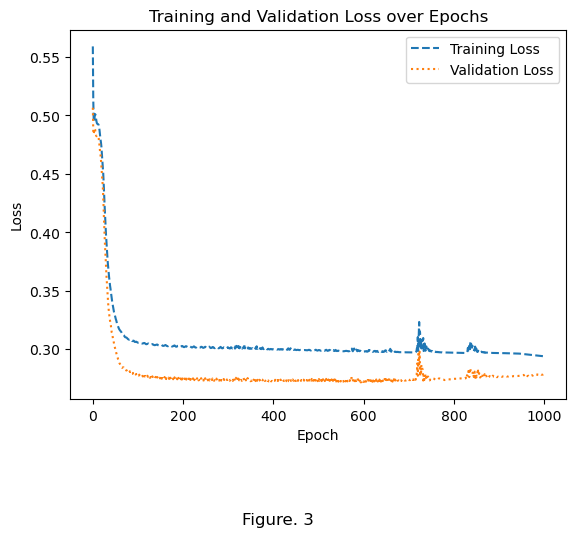

In [25]:
# Set seeds for reproducibility
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,)),  # Adjust input shape based on feature count
    tf.keras.layers.Dense(8, activation='linear'),
    tf.keras.layers.Dense(23, activation='relu'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.026526058661021926)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 1000 epochs (each epoch uses the full training set, i.e. BGD)
history = model.fit(X_train, y_train, epochs=1000, batch_size=len(X_train), verbose=0,
                   validation_data=(X_val, y_val))

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss', linestyle="--")                # Extract training loss values from history
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle=":")           # Extract validation loss values from history
plt.xlabel('Epoch')                                                                     # Label x-axis as 'Epoch'
plt.ylabel('Loss')                                                                      # Label y-axis as 'Loss'
plt.title('Training and Validation Loss over Epochs')                                   # Add a title to the plot
plt.legend()                                                                            # Add a legend
plt.figtext(0.45, -0.15, "Figure. 3", ha="center", fontsize=12)
plt.show()     


In [24]:
# Using Kfold cross validation
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from tensorflow.keras.models import clone_model
from sklearn.metrics import f1_score

# Set seeds for reproducibility
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# List of epoch values to test
epoch_list = [50,75, 100, 125, 150,175, 200, 225, 250, 275, 300,325, 350,375, 400,425, 450,475, 500]
results = {}

# Creating the model
final_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,)),  # Adjust input shape based on feature count
    tf.keras.layers.Dense(8, activation='linear'),
    tf.keras.layers.Dense(23, activation='relu'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Assume X, y are your input data and labels, and final_model is your tuned Keras model
kf = KFold(n_splits=5, shuffle=True, random_state=888)

for epoch in epoch_list:
    f1_scores = []
    for train_idx, val_idx in kf.split(X, y):
        # Split data for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        scaler = StandardScaler()
        age_index = 1
        # Fit the scaler only on the age column in X_train
        X_train_age = X_train[:, age_index].reshape(-1, 1)
        scaler.fit(X_train_age)
        # Transform the age column in X_train and X_val
        X_train[:, age_index] = scaler.transform(X_train_age).flatten()
        X_val[:, age_index] = scaler.transform(X_val[:, age_index].reshape(-1, 1)).flatten()

        # Clone the model to reset weights for each fold
        model = clone_model(final_model)
        opt = tf.keras.optimizers.Adam(learning_rate=0.026526058661021926)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
        # Train the model on this fold
        model.fit(X_train, y_train, epochs=epoch, batch_size=len(X_train), verbose=0)
    
        # Predict and evaluate F1 score for this fold
        y_pred = (model.predict(X_val) > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        
    results[epoch] = np.mean(f1_scores)
    print(f"Average F1 Score for {epoch} epochs: {results[epoch]}")



StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
Average F1 Score for 50 epochs: 0.9419196653425923


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step 
Average F1 Score for 75 epochs: 0.9449669571456468


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
Average F1 Score for 100 epochs: 0.9342043310804758


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
Average F1 Score for 125 epochs: 0.945155164642531


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
Average F1 Score for 150 epochs: 0.9452346114311811


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
Average F1 Score for 175 epochs: 0.9453143941507147


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
Average F1 Score for 200 epochs: 0.9453307249239218


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
Average F1 Score for 225 epochs: 0.9346166638549299


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
Average F1 Score for 250 epochs: 0.9452282652682996


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
Average F1 Score for 275 epochs: 0.9354824442663547


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
Average F1 Score for 300 epochs: 0.9451845453393741


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
Average F1 Score for 325 epochs: 0.9455186292284322


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
Average F1 Score for 350 epochs: 0.9238356885079018


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step
Average F1 Score for 375 epochs: 0.9456697057027841


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
Average F1 Score for 400 epochs: 0.9345612737982518


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
Average F1 Score for 425 epochs: 0.9455419517252782


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
Average F1 Score for 450 epochs: 0.9454382088972448


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
Average F1 Score for 475 epochs: 0.9357945877202809


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
Average F1 Score for 500 epochs: 0.9341001347127836


{50: 0.9419196653425923,
 75: 0.9449669571456468,
 100: 0.9342043310804758,
 125: 0.945155164642531,
 150: 0.9452346114311811,
 175: 0.9453143941507147,
 200: 0.9453307249239218,
 225: 0.9346166638549299,
 250: 0.9452282652682996,
 275: 0.9354824442663547,
 300: 0.9451845453393741,
 325: 0.9455186292284322,
 350: 0.9238356885079018,
 375: 0.9456697057027841,
 400: 0.9345612737982518,
 425: 0.9455419517252782,
 450: 0.9454382088972448,
 475: 0.9357945877202809,
 500: 0.9341001347127836}

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'F1 Score')

Text(0.5, 1.0, 'Line Graph of Epoch against F1 score')

Text(130, 0.9302346114311811, 'Max Chosen\n(X=150, Y=0.9452)')

Text(0.45, -0.15, 'Figure. 4')

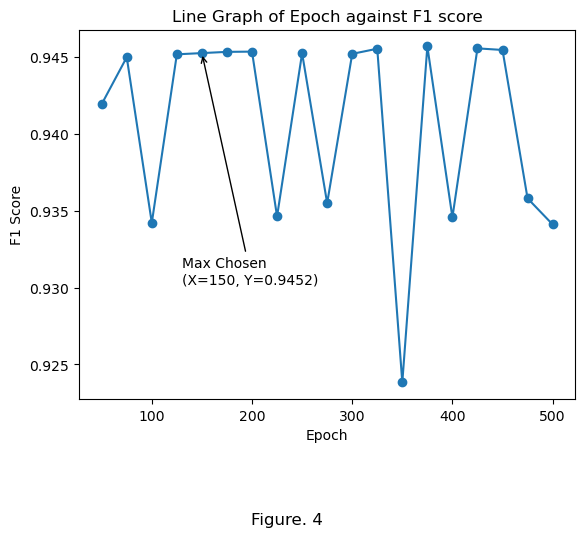

In [26]:
results # Epoch 150 is the ideal value

# Plotting the data as a line graph
x_values = list(results.keys())
y_values = list(results.values())
# Coordinates for annotation
x_annotation = 150
y_annotation = results[x_annotation]

plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Line Graph of Epoch against F1 score')
plt.annotate(f'Max Chosen\n(X=150, Y={y_annotation:.4f})',
             xy=(x_annotation, y_annotation), xytext=(x_annotation-20, y_annotation-0.015),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.figtext(0.45, -0.15, "Figure. 4", ha="center", fontsize=12)
plt.show()

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

Text(0.45, -0.15, 'Figure. 5')

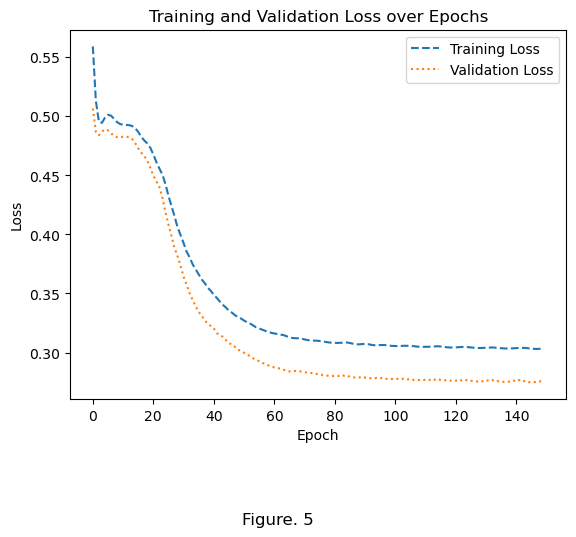

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
Best model Precision on validation set: 0.9096573208722741
Best model Recall on validation set: 1.0
Best model F1 score on validation set: 0.9526916802610114


In [27]:
# Set seeds for reproducibility
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,)),  # Adjust input shape based on feature count
    tf.keras.layers.Dense(8, activation='linear'),
    tf.keras.layers.Dense(23, activation='relu'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.026526058661021926)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 150 epochs (each epoch uses the full training set, i.e. BGD)
history = model.fit(X_train, y_train, epochs=150, batch_size=len(X_train), verbose=0,
                   validation_data=(X_val, y_val))

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss', linestyle="--")                # Extract training loss values from history
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle=":")           # Extract validation loss values from history
plt.xlabel('Epoch')                                                                     # Label x-axis as 'Epoch'
plt.ylabel('Loss')                                                                      # Label y-axis as 'Loss'
plt.title('Training and Validation Loss over Epochs')                                   # Add a title to the plot
plt.legend()                                                                            # Add a legend
plt.figtext(0.45, -0.15, "Figure. 5", ha="center", fontsize=12)
plt.show()     

# Make predictions on the validation set
y_val_pred = (model.predict(X_val) > 0.5).astype("int32")  # Threshold at 0.5 for binary classification

# Calculate F1 score
f1 = f1_score(y_val,y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

print("Best model Precision on validation set:", precision)
print("Best model Recall on validation set:", recall)
print("Best model F1 score on validation set:", f1)